# 1. Clustering-Based Anomaly Detection: K-Means

## Concept & Theory

- The core idea behind using k-means for anomaly detection is to group data points into clusters. Normal data points will tend to be close to the center of a cluster (centroid), while anomalies will be far from any cluster centroid. The distance of a data point from its nearest cluster centroid can be used as an anomaly score.

1. **Clustering**: The k-means algorithm partitions the data into *k* clusters by minimizing the within-cluster sum of squares (WCSS):

    $$ \text{WCSS} = \sum_{i=1}^{k} \sum_{x \in C_i} ||x - \mu_i||^2 $$

    where $C_i$ is the $i$-th cluster and $\mu_i$ is its centroid.

2. **Anomaly Score**: For any data point $x$, its anomaly score is its Euclidean distance to the nearest centroid:

$$ \text{Anomaly Score}(x) = \min_{i=1,...,k} ||x - \mu_i||^2 $$

3. **Thresholding**: A threshold is set on the anomaly scores to classify points as anomalies. A common approach is to use a quantile of the distances.

## Python Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

### 1. Generate Sample Data

In [8]:
# Generate isotropic Gaussian blobs for clustering\n",
X, _ = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=0)
print(X.shape)
# Add some outliers,
outliers = np.array([[0, 5],[6, 2]])
X = np.concatenate([X, outliers])


(300, 2)


### 2. Fit K-Means Model


In [9]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init=10).fit(X)

### 3. Calculate Anomaly Scores


In [10]:
# Calculate the distance from each point to its closest cluster center,
distances = np.min(kmeans.transform(X), axis=1)

# Set an anomaly threshold (e.g., 95th percentile),
threshold = np.quantile(distances, 0.95)

# Identify anomalies,
anomalies = X[distances > threshold]


### 4. Visualize Results


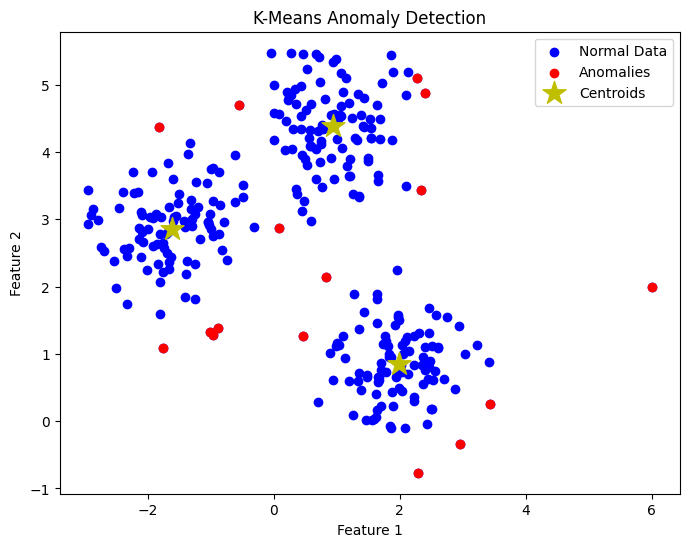

In [11]:
plt.figure(figsize=(8, 6)),
plt.scatter(X[:, 0], X[:, 1], c='b', label='Normal Data'),
plt.scatter(anomalies[:, 0], anomalies[:, 1], c='r', label='Anomalies'),
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='y', marker='*', label='Centroids'),
plt.title('K-Means Anomaly Detection'),
plt.xlabel('Feature 1'),
plt.ylabel('Feature 2'),
plt.legend(),
plt.show()


## Pros & Cons
### Pros
- **Simple and easy to implement.**: K-means is a well-understood algorithm.
- **Efficient**: It is computationally efficient for large datasets.
- **Scalable**: The algorithm scales well to a large number of samples.

### Cons
- **Requires specifying *k***: The number of clusters must be set beforehand.
- **Assumes spherical clusters**: K-means performs poorly on clusters with complex shapes.
- **Sensitive to initialization**: The initial placement of centroids can affect the final clustering

## When to Use
K-means is a good choice for anomaly detection when:
- The clusters are expected to be roughly spherical.
- The number of clusters (*k*) is known or can be estimated.
- The dataset is large and computational efficiency is important.


# 2. Clustering-Based Anomaly Detection: DBSCAN


## Concept & Theory
- DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a density-based clustering algorithm. The main idea is that a point is a core point if it has at least a minimum number of other points (MinPts) within a given radius (epsilon). Clusters are built by connecting core points that are close to each other. Points that are not part of any cluster are considered noise, which makes DBSCAN naturally suited for anomaly detection.

## Mathematical Overview

DBSCAN has two key parameters:

- **epsilon (eps)**: The radius of the neighborhood around a point.
- **MinPts**: The minimum number of points required to form a dense region.

Based on these parameters, points are classified as:

- **Core point**: A point that has at least MinPts points (including itself) in its eps-neighborhood.
- **Border point**: A point that is not a core point but is in the eps-neighborhood of a core point.
- **Noise point (Anomaly)**: A point that is neither a core point nor a border point. These are the points that are considered anomalies.

## Python Implementation


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons


### 1. Generate Sample Data


In [13]:
# Generate non-spherical data,
X, _ = make_moons(n_samples=300, noise=0.05, random_state=0)

# Add some outliers
outliers = np.array([[-1, 1.5], [2, 1]])
X = np.concatenate([X, outliers])


### 2. Fit DBSCAN Model


In [14]:
dbscan = DBSCAN(eps=0.2, min_samples=5).fit(X)


### 3. Identify Anomalies


In [15]:
# Anomalies are labeled as -1 by DBSCAN
anomalies = X[dbscan.labels_ == -1]


### 4. Visualize Results

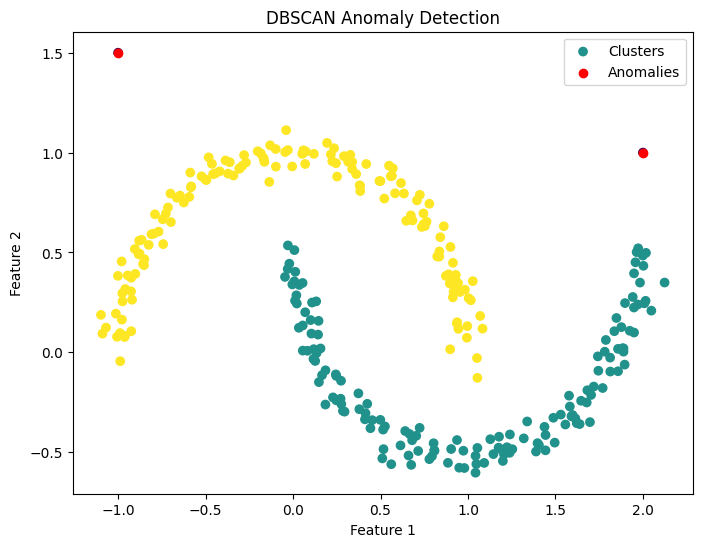

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=dbscan.labels_, cmap='viridis', label='Clusters')
plt.scatter(anomalies[:, 0], anomalies[:, 1], c='r', label='Anomalies')
plt.title('DBSCAN Anomaly Detection')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


## Pros & Cons

### Pros

- **Can find arbitrarily shaped clusters.**: It is not limited to spherical clusters.
- **Does not require specifying the number of clusters.**: The algorithm finds the number of clusters on its own.
- **Robust to outliers**: DBSCAN is designed to identify and handle noise.

### Cons

- **Sensitive to parameters**: The choice of `eps` and `MinPts` can be difficult and has a large impact on the results.
- **Struggles with varying density**: It can be challenging to find a good set of parameters for clusters with varying densities.,
- **Curse of dimensionality**: The distance metric can be less meaningful in high-dimensional spaces.

## When to Use

DBSCAN is a good choice for anomaly detection when:
- The clusters have complex shapes.
- The number of clusters is unknown.
- The dataset contains noise and outliers that need to be identified.
